# testing otpimizations

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/nmf-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies
        !git clone https://github.com/inspektral/music2latent.git

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils
import test_signals


In [13]:
tests = test_signals.get_tests()
print(f"{len(tests)} tests found:")
for key in tests.keys():
    print(f"{key}")

print("available metrics:")
print(utils.get_available_metrics())

print("available representations:")
print(utils.get_available_representations())

13 tests found:
square_slow
square_fast
square_vibrato
saw_noise
sines_noise
filter_saw
triangle_clip
fm_amplitude
fm_frequency
delay_noise
delay_saw
reverb_noise
reverb_saw
available metrics:
['magnitude', 'distances', 'cosine_similarity']
available representations:
['mfcc', 'cqt', 'spectrum', 'music2latent', 'dac']


In [5]:
TEST = "sines_noise"
REPR = "music2latent"
METRIC = "magnitude"

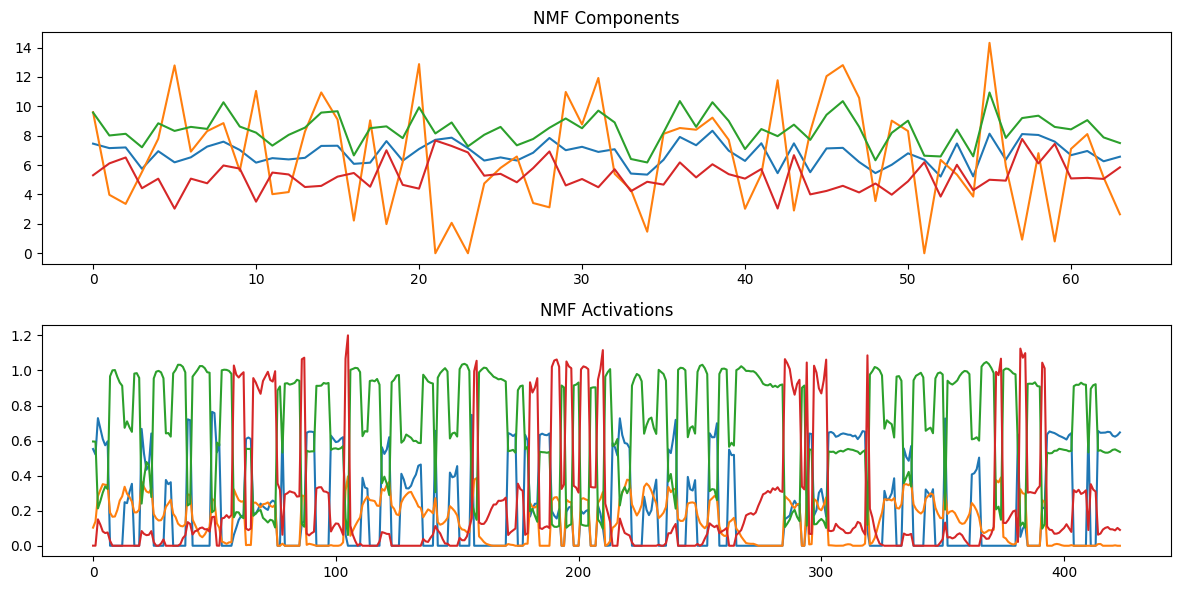

In [6]:
audio, modulator = tests[TEST]()
length = int(len(modulator) / 10)

def norm_stretch(arr, length):
    arr = utils.norm(arr)
    arr = utils.stretch_array(arr, length)
    return arr

modulator = norm_stretch(modulator, length)
repr = utils.calc_representation(audio, REPR)
minimum = np.abs(np.min(repr))
repr = repr + minimum

# NMF
import librosa

components, activations = librosa.decompose.decompose(
    repr+minimum,
    n_components=4,
    sort=True,
    random_state=42
)

display(Audio(audio, rate=44100))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(components)
plt.title('NMF Components')
plt.subplot(2, 1, 2)
plt.plot(activations.T)
plt.title('NMF Activations')
plt.tight_layout()
plt.show()

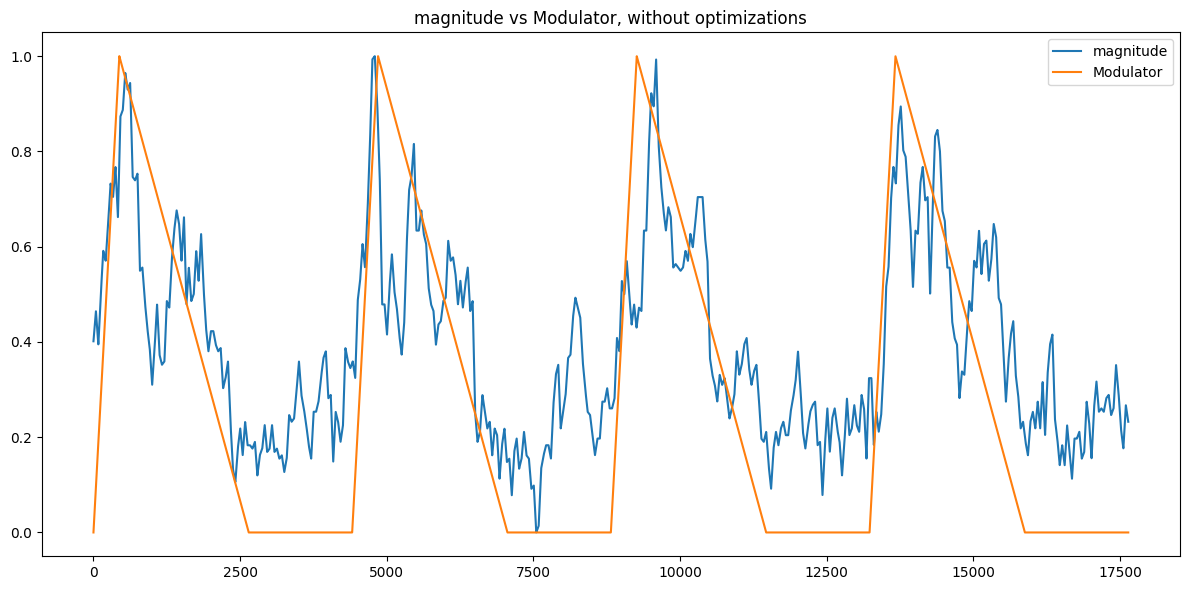

In [7]:
metric = utils.calc_metric(repr, METRIC)
metric = utils.norm_stretch(metric, length)

plt.figure(figsize=(12, 6))
plt.plot(metric, label=METRIC)
plt.plot(modulator, label='Modulator')
plt.title(f'{METRIC} vs Modulator, without optimizations')
plt.legend()
plt.tight_layout()
plt.show()

Best exponent: 0.9492453030698998
Best smooth: 768
Correlation between modulator and magnitude: 0.9280


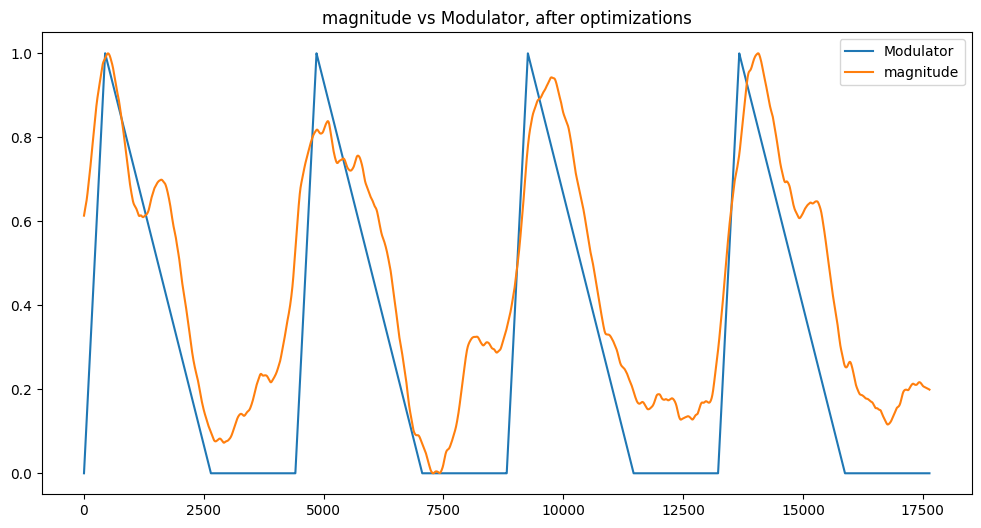

In [8]:
best_exponent = utils.calc_best_exponent(metric, modulator)
print(f"Best exponent: {best_exponent}")
metric = utils.norm(metric ** best_exponent)

best_smooth = utils.calc_best_smoothing(metric, modulator)
print(f"Best smooth: {best_smooth}")
metric = utils.norm(utils.smooth(metric, best_smooth))
correlation = utils.calc_correlation(modulator, metric)
print(f"Correlation between modulator and magnitude: {correlation:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(modulator, label='Modulator')
plt.plot(metric, label=METRIC)
plt.title(f'{METRIC} vs Modulator, after optimizations')
plt.legend()
plt.show()



Activation 0 correlation: -0.1530
Activation 1 correlation: 0.8473
Activation 2 correlation: 0.4551
Activation 3 correlation: -0.7374
Best activation index: 1 with correlation 0.8473


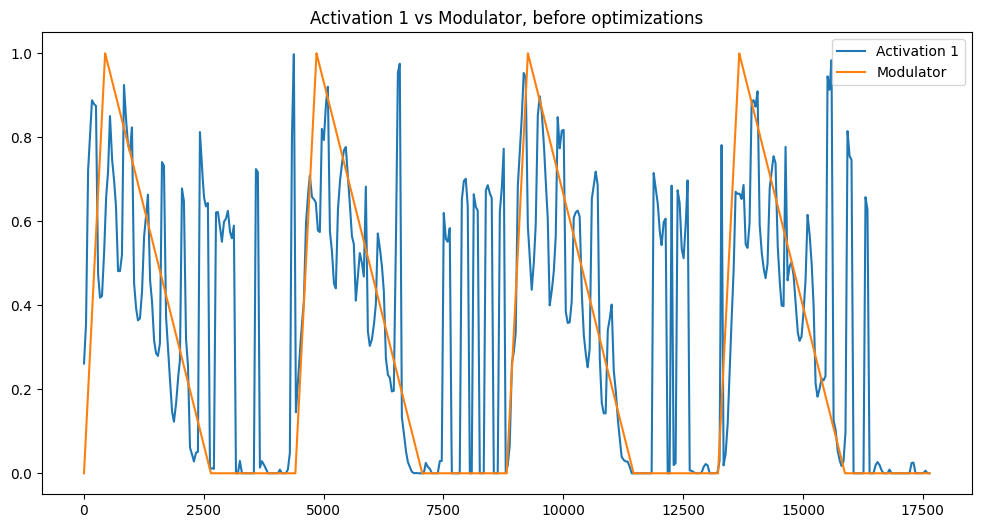

In [9]:
correlations = []

for i in range(activations.shape[0]):
    activation = norm_stretch(activations[i], length)
    activation = utils.smooth(activation, best_smooth)
    activation = norm_stretch(activation, length)
    correlation = utils.calc_correlation(modulator, activation)
    correlations.append(np.abs(correlation))
    print(f"Activation {i} correlation: {correlation:.4f}")

best_index = np.argmax(correlations)
print(f"Best activation index: {best_index} with correlation {correlations[best_index]:.4f}")
activation = norm_stretch(activations[best_index], length)



plt.figure(figsize=(12, 6))
plt.plot(activation, label=f'Activation {best_index}')
plt.plot(modulator, label='Modulator')
plt.title(f'Activation {best_index} vs Modulator, before optimizations')
plt.legend()
plt.show()

Best smooth for activation 1: 1136
Correlation between modulator and activation 1: 0.8555


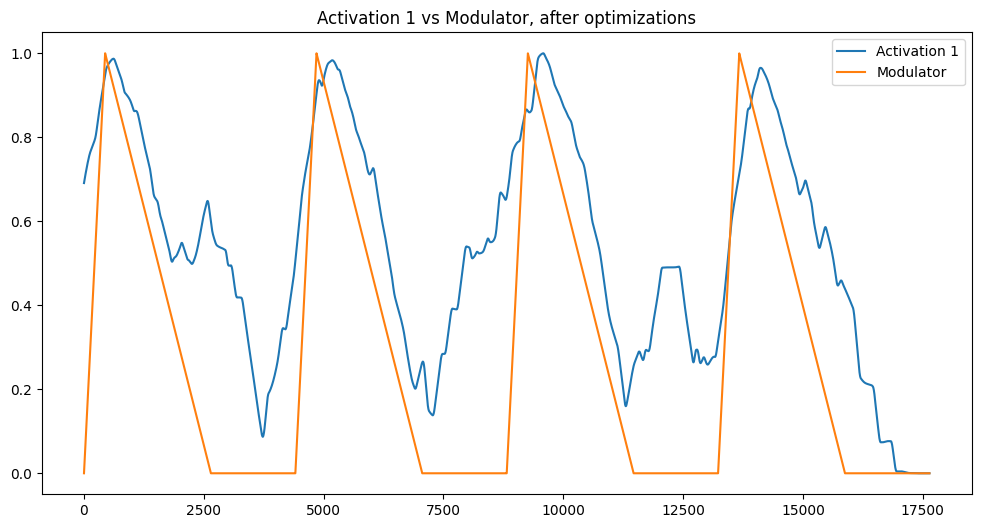

In [10]:
best_smooth = utils.calc_best_smoothing(activation, modulator)
print(f"Best smooth for activation {best_index}: {best_smooth}")
activation = utils.norm(utils.smooth(activation, best_smooth))
correlation = utils.calc_correlation(modulator, activation)
print(f"Correlation between modulator and activation {best_index}: {correlation:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(activation, label=f'Activation {best_index}')
plt.plot(modulator, label='Modulator')
plt.title(f'Activation {best_index} vs Modulator, after optimizations')
plt.legend()
plt.show()